In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 6.2 Rotation around the origin

In [2]:
def nice_plot(ax):
    ax.set(xlabel='$x$', ylabel='$y$', xlim=[-2.2, 4.2], ylim=[-2.2, 4.2], aspect='equal')
    ax.grid(alpha=0.5)
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)

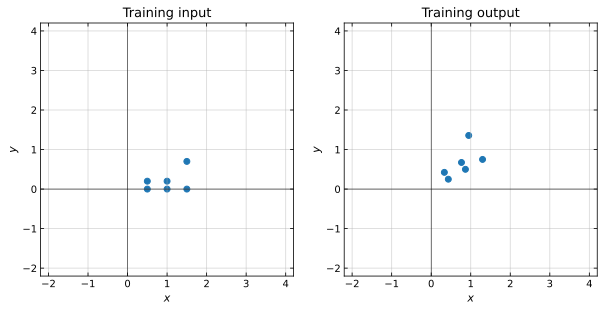

In [3]:
x_train = torch.tensor([[0.5, 0], [1.0, 0], [1.5, 0], [0.5, 0.2], [1.0, 0.2], [1.5, 0.7]])
theta = np.pi / 6
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
y_train = (torch.tensor(rotation_matrix, dtype=torch.float32) @ x_train.T).T

# Plot the points
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*x_train.T)
axs[0].set_title('Training input')
axs[1].scatter(*y_train.T)
axs[1].set_title('Training output')
for ax in axs:
    nice_plot(ax)

fig.savefig('ex50_fig1.png')

### 6.3 Linear model without bias

In [4]:
def do_one_fit(Model, ax, text_with_params=False, learning_rate=0.01, steps=5000, print_results=False, Nrots=5, **kwargs):
    model = Model()

    # for name, parameter in model.named_parameters():
    #     print(name, parameter.shape, parameter.data)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = torch.nn.MSELoss()

    for i in tqdm(range(steps), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

        # if (i+1) % 1000 == 0:
        #     print(f'Step [{i+1}/{steps}], Loss: {loss_value.item():.4f}')
    
    if print_results:
        for name, parameter in model.named_parameters():
            print(f'Name: {name}, Parameters: {parameter.shape}, {parameter.data}, loss: {loss_value.item():.4f}')
    
    cmap = plt.get_cmap('RdYlGn')
    colors = [cmap(i) for i in np.linspace(0, 1, Nrots)]
    with torch.no_grad():
        fit = x_train
        for i in range(Nrots):
            fit = model(fit)
            ax.scatter(*fit.T, color=colors[i])
    nice_plot(ax)
    ax.set(**kwargs)
    if text_with_params:
        text = ''
        for name, parameter in model.named_parameters():
            if text != '':
                text += '\n'
            text += f'{name}: {parameter.data.numpy()}'
        ax.text(0.05, 0.95, text, transform=ax.transAxes, backgroundcolor='white', ha='left', va='top')

In [5]:
class LinearModelWithoutBias(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2, bias=False)
    
    def forward(self, x):
        x = self.layer1(x)
        return x

Training: 100%|██████████| 5000/5000 [00:02<00:00, 2477.10it/s]


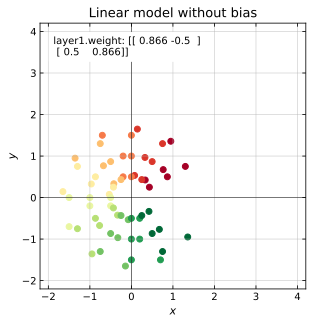

In [6]:
fig, ax = plt.subplots()
do_one_fit(LinearModelWithoutBias, ax, text_with_params=True, Nrots=10, title='Linear model without bias')

fig.savefig('ex50_fig2.png')

### 6.4 Linear model with bias

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.layer1(x)
        return x

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training: 100%|██████████| 5000/5000 [00:02<00:00, 2335.84it/s]


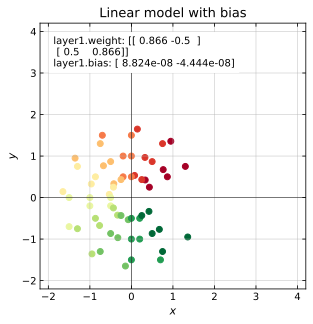

In [8]:
fig, ax = plt.subplots()
do_one_fit(LinearModel, ax, text_with_params=True, Nrots=10, title='Linear model with bias')

fig.savefig('ex50_fig3.png')

### 6.5 Two linear models with bias

In [9]:
class TwoLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

Training: 100%|██████████| 5000/5000 [00:02<00:00, 2065.65it/s]


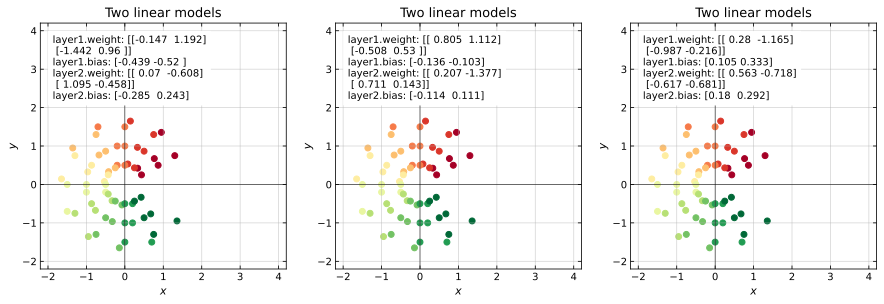

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    do_one_fit(TwoLinearModel, ax, text_with_params=True, Nrots=10, title='Two linear models')

fig.savefig('ex50_fig4.png')

So the bias is essentially zero each time. This means that the fit without the bias was already the "coorect" solution.

### 6.6 Data rotated around a point

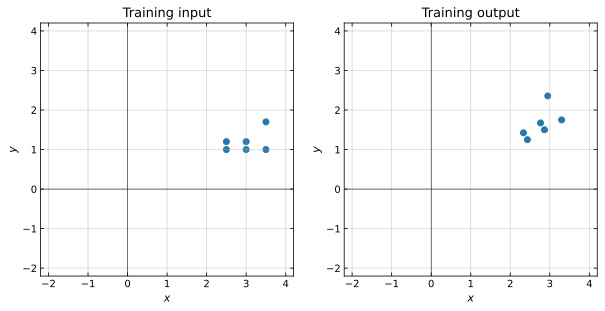

In [11]:
# In the rest of the exercise, data that is rotated around a point different from the origin will be used.
x_train = torch.tensor([[2.5, 1], [3.0, 1], [3.5, 1], [2.5, 1.2], [3.0, 1.2], [3.5, 1.7]])
theta = np.pi / 6
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotation_point = torch.tensor([2.0, 1.0])
y_train = (torch.tensor(rotation_matrix, dtype=torch.float32) @ (x_train - rotation_point).T).T + rotation_point

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*x_train.T)
axs[0].set_title('Training input')
axs[1].scatter(*y_train.T)
axs[1].set_title('Training output')
for ax in axs:
    nice_plot(ax)

fig.savefig('ex50_fig5.png')

### 6.7 Linear model without bias

Training: 100%|██████████| 5000/5000 [00:01<00:00, 3428.62it/s]


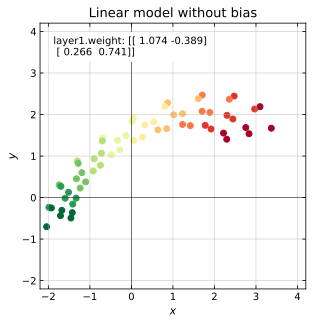

In [12]:
# Now see if you can fit the Linear model without bias to this set of data.
fig, ax = plt.subplots()
do_one_fit(LinearModelWithoutBias, ax, text_with_params=True, Nrots=10, title='Linear model without bias')

fig.savefig('ex50_fig6.png')

### 6.8 Linear model with bias

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2686.13it/s]


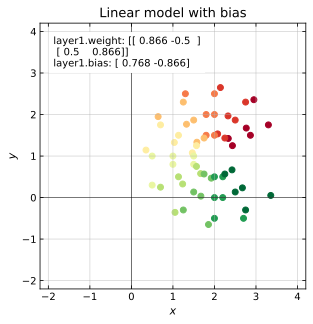

In [13]:
# Add the bias and inspect what it ends up being.
fig, ax = plt.subplots()
do_one_fit(LinearModel, ax, text_with_params=True, Nrots=10, title='Linear model with bias')

fig.savefig('ex50_fig7.png')

### 6.9 Two linear models with bias

Training: 100%|██████████| 5000/5000 [00:02<00:00, 2075.45it/s]


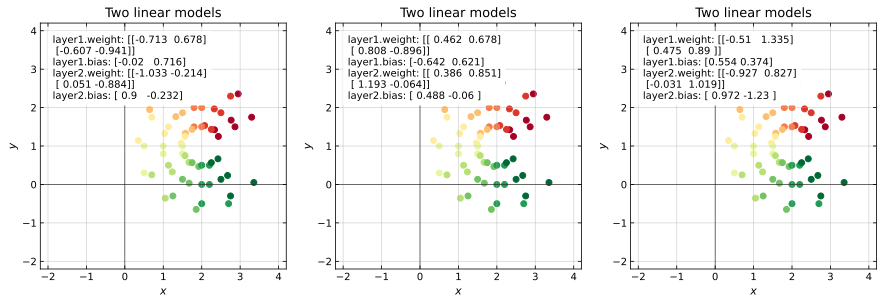

In [14]:
# See if two consecutive linear models with bias can be fitted. We now have 12 parameters and 12 coordinates to fit.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    do_one_fit(TwoLinearModel, ax, text_with_params=True, Nrots=10, title='Two linear models')

fig.savefig('ex50_fig8.png')

### 6.10 Two linear models without bias

In [15]:
class TwoLinearModelWithoutBias(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2, bias=False)
        self.layer2 = torch.nn.Linear(2, 2, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2740.61it/s]


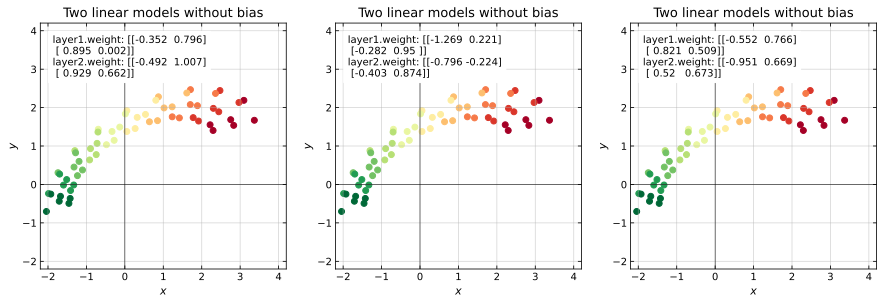

In [16]:
# Remove the two biases. Explain the effect.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    do_one_fit(TwoLinearModelWithoutBias, ax, text_with_params=True, Nrots=10, title='Two linear models without bias')

fig.savefig('ex50_fig9.png')

The effect occurs because two consecutive linear models essentially is just a single linear model:

**SEJ OPDAGELSE TIL PORTFOLIET**

Hvis man bare stacker lineære lag på hinanden, gør det ikke netværket bedre!
\begin{align}
    y &= w_3(w_2(w_1x+b_1)+b_2)+b_3 \\
    &= (w_3w_2w_1)x + (w_3w_2b_1) + w_3b_2 + b_3 \\
    &= w'x + b'
\end{align}

Altså er et arbitrært antal lineære lag anvendt på hinanden til slut bare et enkelt lineært lag.

Hvis man inkluderer en activation function,
\begin{align}
    y &= w_3(w_2f_1(w_1x+b_1)+b_2)+b_3,
\end{align}
er det ikke længere det samme. Her gør det en forskel at stacke flere lineære lag på!

### 6.11 A rich model

In [17]:
# Make model with way too many parameters. Say one with three layers, a 2x8 layer, a 8x8 layer, and a 8x2 layer. Can that be trained?
class RichModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 8)
        self.layer2 = torch.nn.Linear(8, 8)
        self.layer3 = torch.nn.Linear(8, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training: 100%|██████████| 5000/5000 [00:03<00:00, 1651.29it/s]


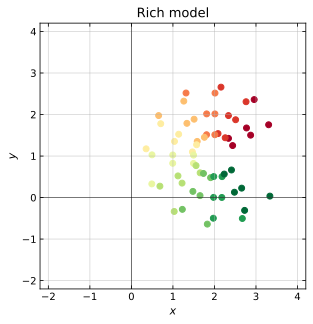

In [18]:
fig, ax = plt.subplots()
do_one_fit(RichModel, ax, text_with_params=False, Nrots=10, title='Rich model')

fig.savefig('ex50_fig10.png')

And we see the same effect again :)